<a href="https://colab.research.google.com/github/Quiirex/GPT_Classifier/blob/main/GPT_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT Klasifikator

**GPT klasifikator** je eksperimentalni klasifikator v obliki razreda, ki deluje s pomočjo OpenAI GPT API storitve in implementira metodi *fit* in *predict*. Ideja je, da se GPT sistematično uporabi za klasifikacijo instanc nad poljubno podatkovno zbirko.

Avtor: Luka Mlinarič Fekonja

## Predpriprava
Uporabimo knjižnico OpenAI, ki omogoča klic OpenAI GPT API storitve.
Uvozimo vse ostale potrebne knjižnice.

In [164]:
!pip install openai --quiet

In [165]:
from openai import OpenAI
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

## Klasifikator

### Metoda *fit*

Za vsako oznako razreda v y izvede naslednje korake:

1. Izvede KMeans gručenje na vzorcih X, ki ustrezajo trenutni oznaki razreda. (Število gruč je privzeto nastavljeno na 5.)
2. Izračuna razdalje do najbližjega središča gruče za vsak vzorec, ki ustreza trenutni oznaki razreda.
3. Ustvari DataFrame z razdaljami in originalnimi indeksi vzorcev.
4. Razvrsti DataFrame po razdaljah in odstrani duplikate, pri čemer ohrani prvo pojavitev vsakega vzorca.
5. Iz DataFrame izbere 5 vzorcev, ki so najbližje središčem gruč, in jih shrani kot prototipne instance za trenutno oznako razreda.

Na koncu je cilj te kode izbrati prototipne instance za vsak razred, ki so najbližje središčem gruč, pridobljenih z algoritmom KMeans. Te instance se nato uporabijo za klasifikacijo novih vzorcev.

### Metoda *predict*

1. Inicializira OpenAI API s podanim API ključem (privzeto je uporabljen model GPT 3.5 turbo).
2. Ustvari seznam za napovedi in seznam za pozive.
3. Dodaja različne pozive v seznam pozivov, vključno s sistemskim pozivom, ki določa format odgovora, in uporabniškimi pozivi, ki predstavljajo prototipne instance vsakega razreda.
4. Za vsako instanco v X doda uporabniški poziv, ki prosi za klasifikacijo te instance glede na prototipne instance.
5. Pošlje vse pozive v OpenAI API in dobi odgovor.
6. Razčleni JSON odgovor in pridobi vrednosti razredov.
7. Preveri, če je število klasifikacij pravilno. Če ni, se odvečne klasifikacije odrežejo oz. manjkajoče klasifikacije zapolnijo s privzeto.
8. Pridobljene vrednosti vrne.

Na koncu je cilj te kode napovedati razred za vsako instanco v X glede na prototipne instance, ki so bile prej izbrane z metodo fit. Napovedi se vrnejo kot seznam številskih vrednosti razredov.


In [166]:
class GPTClassifier:
    """
    A classifier that uses the GPT API from OpenAI to classify instances.
    """
    def __init__(self, api_key="", model="gpt-3.5-turbo-1106", random_state=42):
        """
        Initializes the classifier with the given API key, model and random state.

        Parameters
        ----------
        openai_api_key : string
            Your personal OpenAI API key.
        model : string, default="gpt-3.5-turbo-1106"
            The GPT model that the classifier will use.
        random_state : int, default=42
            The seed used by the random number generator.
        """
        self.api_key = api_key
        self.model = model
        self.prototype_instances = {}
        self.random_state = random_state
        self.no_instances = 0

    def fit(self, X, y):
        """
        Fits the classifier to the given data X with labels y.

        Parameters
        ----------
        X : array-like
            The input samples to fit on.
        y : array-like
            The target values.
        """
        for class_label in set(y):
            # KMeans gručenje
            kmeans = KMeans(n_clusters=5, random_state=self.random_state)
            kmeans.fit(X[y == class_label])

            # Pridobimo razdalje do najbližjega središča gruče za vsako instanco
            dists, _ = pairwise_distances_argmin_min(X[y == class_label], kmeans.cluster_centers_)

            # Ustvarimo DataFrame z razdaljami in originalnimi indeksi
            original_indices = np.where(y == class_label)[0]
            df_dists = pd.DataFrame({'dist': dists, 'idx': original_indices})

            # Razvrstimo po razdalji in odstranimo duplikate
            df_dists.sort_values('dist', inplace=True)
            df_dists.drop_duplicates(subset='idx', keep='first', inplace=True)

            # Pridobimo 5 najboljših unikatnih instanc, ki so najbližje središčem gruče
            top_indices = df_dists['idx'].values[:5]
            self.prototype_instances[class_label] = X[top_indices]

    def predict(self, X):
        """
        Predicts the class of the given instances X.

        Parameters
        ----------
        X : array-like
            The input samples to predict.

        Returns
        -------
        array-like
            The predicted class labels for each instance in X.
        """
        # Inicializacija OpenAI API
        client = OpenAI(api_key=self.api_key)

        # Seznam za predikcije
        predictions = []

        # Seznam za pozive
        prompts = []

        # Sistemski poziv
        prompts.append({"role": "system", "content": 'You are a classifier that has to decide to which class an instance belongs to. Always answer strictly in the following JSON format: {"class":[<class of first instance>, <class of second instance>, ..., <class of last instance>]}'})

        # Uporabniški poziv o prototipnih instancah
        prompts.append({"role": "user", "content": "Here are the 5 most prototypic instances of each class for this dataset:"})

        # Uporabniški poziv za vsako prototipno instanco
        for class_label, instances in self.prototype_instances.items():
            for j, instance_i in enumerate(instances):
                prompts.append({"role": "user", "content": f"Class: '{class_label}', Instance: {instance_i}"})

        for i, x in enumerate(X):
            # Uporabniški poziv za vsako novo (še ne-videno) instanco
            self.no_instances += 1
            prompts.append({"role": "user", "content": f"{i+1}. According to the prototypic instances, classify the following instance: {x}\n"})

        # Uporabniški poziv s pomočjo katerega modelu povemo koliko klasifikacij more narediti. Pogosta težava je, da naredi premalo/preveč klasifikacij
        prompts.append({"role": "user", "content": f"You need to classify {self.no_instances} instances in total."})

        # Pošiljanje vseh pozivov in klasifikacija
        response = client.chat.completions.create(
            model=self.model,
            messages=prompts,
            response_format={'type': 'json_object'}
        )

        # Razčlenitev JSON odgovora
        assert response.choices[0].message.content is not None
        parsed_response = json.loads(response.choices[0].message.content)
        class_values = parsed_response["class"]

        # Pretvorimo vrednosti v številske vrednosti
        class_values = np.array([int(value) for value in class_values])

        # Preverimo, ali je število klasifikacij pravilno
        if len(class_values) < self.no_instances:
            # Če je klasifikacij premalo, dodamo privzete klasifikacije za manjkajoče
            class_values += [0] * (self.no_instances - len(class_values))
        elif len(class_values) > self.no_instances:
            # Če je klasifikacij preveč, zavržemo odvečne
            class_values = class_values[:self.no_instances]

        return class_values

## Priprava (obdelava) in čiščenje podatkovne zbirke

Klasifikator deluje na poljubni podatkovni zbirki. Za primer je uporabljena podatkovna zbirka podatkov bolnikov, ki so bili identificirani s Parkinsonovo boleznijo.

In [167]:
# Naložimo podatkovno zbirko
dataset = pd.read_csv('/content/drive/MyDrive/Colab datasets/Parkinsons.csv')

# Predprocesiramo podatkovno zbirko
df = dataset.drop(columns=['name'])
X = df.drop(columns=['status'])
y = df['status']

# Skaliramo značilke
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podatke razdelimo na učne in testne
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Uporaba klasifikatorja z modelom GPT 3.5 turbo

In [168]:
# Instanciranje klasifikatorja s podanim API ključem, modelom in naključnim stanjem
clf_3_5 = GPTClassifier(api_key=userdata.get('OpenAI_API_Key'), model='gpt-3.5-turbo-1106', random_state=42)

# Prileganje modela
clf_3_5.fit(X_train, y_train)

# Predikcija (klasifikacija)
y_pred_gpt_3_5 = clf_3_5.predict(X_test)

# Metrike
accuracy_gpt_3_5 = accuracy_score(y_test, y_pred_gpt_3_5)
f1_gpt_3_5 = f1_score(y_test, y_pred_gpt_3_5)
precision_gpt_3_5 = precision_score(y_test, y_pred_gpt_3_5)
recall_gpt_3_5 = recall_score(y_test, y_pred_gpt_3_5)
print(f"Accuracy Score of GPT Classifier using GPT 3.5 model: {accuracy_gpt_3_5}")
print(f"F1 Score of GPT Classifier using GPT 3.5 model: {f1_gpt_3_5}")
print(f"Precision Score of GPT Classifier using GPT 3.5 model: {precision_gpt_3_5}")
print(f"Recall Score of GPT Classifier using GPT 3.5 model: {recall_gpt_3_5}")

Accuracy Score of GPT Classifier using GPT 3.5 model: 0.46153846153846156
F1 Score of GPT Classifier using GPT 3.5 model: 0.5882352941176471
Precision Score of GPT Classifier using GPT 3.5 model: 0.7894736842105263
Recall Score of GPT Classifier using GPT 3.5 model: 0.46875


## Uporaba klasifikatorja z modelom GPT 4

In [169]:
# Instanciranje klasifikatorja s podanim API ključem, modelom in naključnim stanjem
clf_4 = GPTClassifier(api_key=userdata.get('OpenAI_API_Key'), model='gpt-4-1106-preview', random_state=42)

# Prileganje modela
clf_4.fit(X_train, y_train)

# Predikcija (klasifikacija)
y_pred_gpt_4 = clf_4.predict(X_test)

# Metrike
accuracy_gpt_4 = accuracy_score(y_test, y_pred_gpt_4)
f1_gpt_4 = f1_score(y_test, y_pred_gpt_4)
precision_gpt_4 = precision_score(y_test, y_pred_gpt_4)
recall_gpt_4 = recall_score(y_test, y_pred_gpt_4)
print(f"Accuracy of GPT Classifier using GPT 4 model: {accuracy_gpt_4}")
print(f"F1 Score of GPT Classifier using GPT 4 model: {f1_gpt_4}")
print(f"Precision Score of GPT Classifier using GPT 4 model: {precision_gpt_4}")
print(f"Recall Score of GPT Classifier using GPT 4 model: {recall_gpt_4}")

Accuracy of GPT Classifier using GPT 4 model: 0.5641025641025641
F1 Score of GPT Classifier using GPT 4 model: 0.6530612244897959
Precision Score of GPT Classifier using GPT 4 model: 0.9411764705882353
Recall Score of GPT Classifier using GPT 4 model: 0.5


## Primerjava z GPT klasifikatorja z ostalimi klasifikatorji

GPT klasifikator primerjamo z drevesom odločanja (DTC), naivnim Bayesom (NB) in naključnim gozdom (RF). Računamo metrike natančnosti (accuracy), f1 mero, točnost (precision) in priklic (recall).

In [170]:
dt = DecisionTreeClassifier(random_state=42)
nb = GaussianNB()
rf = RandomForestClassifier(random_state=42)

dt.fit(X_train, y_train)
nb.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_rf = rf.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

f1_score_dt = f1_score(y_test, y_pred_dt)
f1_score_nb = f1_score(y_test, y_pred_nb)
f1_score_rf = f1_score(y_test, y_pred_rf)

precision_score_dt = precision_score(y_test, y_pred_dt)
precision_score_nb = precision_score(y_test, y_pred_nb)
precision_score_rf = precision_score(y_test, y_pred_rf)

recall_score_dt = recall_score(y_test, y_pred_dt)
recall_score_nb = recall_score(y_test, y_pred_nb)
recall_score_rf = recall_score(y_test, y_pred_rf)

print(f"Accuracy of Decision Tree: {accuracy_dt}")
print(f"Accuracy of Naive Bayes: {accuracy_nb}")
print(f"Accuracy of Random Forest: {accuracy_rf}")
print(f"Accuracy of GPT Classifier using GPT 3.5 model: {accuracy_gpt_3_5}")
print(f"Accuracy of GPT Classifier using GPT 4 model: {accuracy_gpt_4}")
print("\n")
print(f"F1 Score of Decision Tree: {f1_score_dt}")
print(f"F1 Score of Naive Bayes: {f1_score_nb}")
print(f"F1 Score of Random Forest: {f1_score_rf}")
print(f"F1 Score of GPT Classifier using GPT 3.5 model: {f1_gpt_3_5}")
print(f"F1 Score of GPT Classifier using GPT 4 model: {f1_gpt_4}")
print("\n")
print(f"Precision Score of Decision Tree: {precision_score_dt}")
print(f"Precision Score of Naive Bayes: {precision_score_nb}")
print(f"Precision Score of Random Forest: {precision_score_rf}")
print(f"Precision Score of GPT Classifier using GPT 3.5 model: {precision_gpt_3_5}")
print(f"Precision Score of GPT Classifier using GPT 4 model: {precision_gpt_4}")
print("\n")
print(f"Recall Score of Decision Tree: {recall_score_dt}")
print(f"Recall Score of Naive Bayes: {recall_score_nb}")
print(f"Recall Score of Random Forest: {recall_score_rf}")
print(f"Recall Score of GPT Classifier using GPT 3.5 model: {recall_gpt_3_5}")
print(f"Recall Score of GPT Classifier using GPT 4 model: {recall_gpt_4}")

Accuracy of Decision Tree: 0.9230769230769231
Accuracy of Naive Bayes: 0.717948717948718
Accuracy of Random Forest: 0.9487179487179487
Accuracy of GPT Classifier using GPT 3.5 model: 0.46153846153846156
Accuracy of GPT Classifier using GPT 4 model: 0.5641025641025641


F1 Score of Decision Tree: 0.9538461538461539
F1 Score of Naive Bayes: 0.8135593220338982
F1 Score of Random Forest: 0.9696969696969697
F1 Score of GPT Classifier using GPT 3.5 model: 0.5882352941176471
F1 Score of GPT Classifier using GPT 4 model: 0.6530612244897959


Precision Score of Decision Tree: 0.9393939393939394
Precision Score of Naive Bayes: 0.8888888888888888
Precision Score of Random Forest: 0.9411764705882353
Precision Score of GPT Classifier using GPT 3.5 model: 0.7894736842105263
Precision Score of GPT Classifier using GPT 4 model: 0.9411764705882353


Recall Score of Decision Tree: 0.96875
Recall Score of Naive Bayes: 0.75
Recall Score of Random Forest: 1.0
Recall Score of GPT Classifier using GPT 3.5 mo

## Grafična predstavitev rezultatov metrik - uspešnosti modelov

Glede na metrike lahko povzamemo, da je uporaba GPT modelov za namene klasifikacije izjemno **eksperimentalna**. GPT klasifikator se na podlagi obeh modelov (3.5 turbo in 4) glede na konkurenco obnese relativno slabo. Preseneča dejstvo, da med obema GPT modeloma ni bistvene razlike, ki je bila sicer pričakovana. Se pa oba modela relativno dobro (vendar še vedno slabše od konkurence) obneseta iz vidika točnosti.

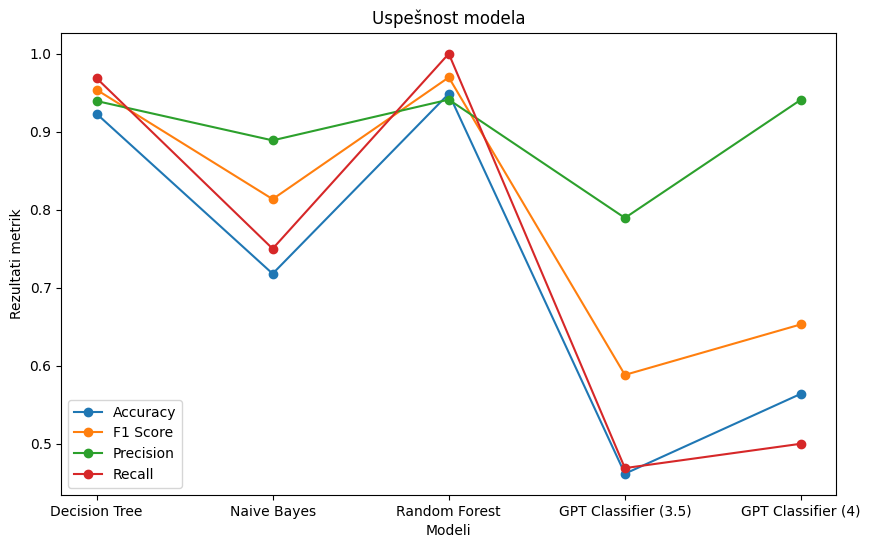

In [173]:
accuracies = [accuracy_dt, accuracy_nb, accuracy_rf, accuracy_gpt_3_5, accuracy_gpt_4]
f1_scores = [f1_score_dt, f1_score_nb, f1_score_rf, f1_gpt_3_5, f1_gpt_4]
precision_scores = [precision_score_dt, precision_score_nb, precision_score_rf, precision_gpt_3_5, precision_gpt_4]
recall_scores = [recall_score_dt, recall_score_nb, recall_score_rf, recall_gpt_3_5, recall_gpt_4]

labels = ['Decision Tree', 'Naive Bayes', 'Random Forest', 'GPT Classifier (3.5)', 'GPT Classifier (4)']

plt.figure(figsize=(10, 6))

plt.plot(labels, accuracies, marker='o', label='Accuracy')
plt.plot(labels, f1_scores, marker='o', label='F1 Score')
plt.plot(labels, precision_scores, marker='o', label='Precision')
plt.plot(labels, recall_scores, marker='o', label='Recall')

plt.title('Uspešnost modela')
plt.xlabel('Modeli')
plt.ylabel('Rezultati metrik')
plt.legend()

plt.show()